In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

## Sk learn imports
from sklearn.linear_model import LogisticRegression, Ridge

## contextualbandit package
from contextualbandits.online import SeparateClassifiers
from contextualbandits.offpolicy import OffsetTree
from contextualbandits.offpolicy import DoublyRobustEstimator

## Plotting
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import math


from matplotlib import pyplot as plt
from matplotlib.pyplot import ylim
from matplotlib.pyplot import figure

%matplotlib inline
import mmap

In [2]:
def get_num_lines(file_path):
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [3]:
def parse_data(filename):
    feature_list = []
    preds = []
    with open(filename, "rb") as f:
        for line in tqdm(f, total=get_num_lines(filename)):
            line = line.decode('ASCII').strip()
            features = line.split(',')
            preds.append(features[0])
            features = features[1:]
            feature_list.append(features)
    return feature_list, preds

features, preds = parse_data("datasets/CNAE-9.data")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 63530.45it/s]


In [4]:
mlb = MultiLabelBinarizer()
preds_list = [[i] for i in preds]
preds_mlb = mlb.fit_transform(preds_list)
features = np.array(features)

temp = list(zip(features, preds_mlb))
random.shuffle(temp)
features, preds_mlb = zip(*temp)

features = np.array(features)
preds_mlb = np.array(preds_mlb)


In [5]:
print(features.shape)
print(preds_mlb.shape)

(1080, 856)
(1080, 9)


In [6]:
y = preds_mlb

In [7]:
features = features.astype(int)

In [8]:
random_slice_index = np.random.choice(y.shape[0], 1000)
random_slice = np.array([y[x] for x in random_slice_index])
print(np.sum(random_slice, axis = 0))
mean_constant = np.sum(y, axis = 0)[np.argmax(np.sum(random_slice, axis = 0))]/y.shape[0]
mean_constant

[117 116 102 110  93 118 114 116 114]


0.1111111111111111

In [9]:
## We can see that there are 1080 rows to  explore so we can split the data into an exploration set
## initial test set
## and then an off-policy set

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed = 0
end_seed = 200

# then it will choose actions for this larger sample
st_exploration = 0
end_exploration = 500

# the new policy will be evaluated with a separate test set
st_test = 500
end_test = 1080

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(solver="sag", max_iter=15000)
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions which will then be used new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [10]:
new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)

Test set mean reward - Separate Classifiers:  0.1103448275862069


In [11]:
new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)

Test set mean reward - Separate Classifiers + Prior:  0.3431034482758621


In [12]:
new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)

Test set mean reward - Separate Classifiers + Smoothing:  0.11724137931034483


In [13]:
new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="sag", max_iter=15000), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

Test set mean reward - Offset Tree technique:  0.8931034482758621


In [14]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)

Test set mean reward - Doubly-Robust Estimator:  0.8517241379310345


In [15]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)

Test set mean reward - Doubly-Robust Estimator + Prior:  0.8517241379310345


In [16]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)

Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.85


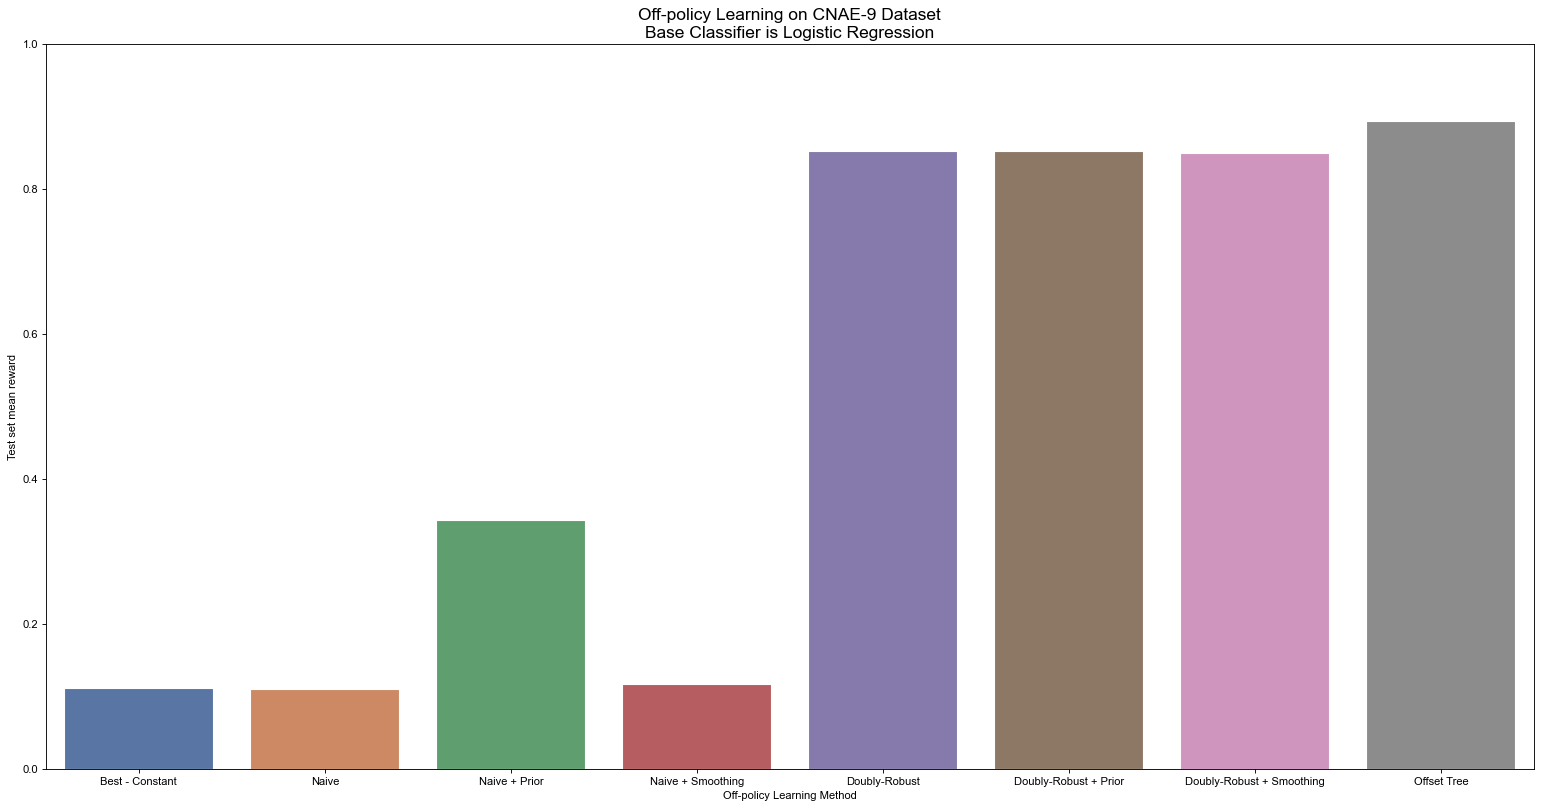

In [17]:
results = pd.DataFrame({
    'Off-policy Learning Method' : ['Best - Constant', 'Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                    'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree'],
    'Test set mean reward' : [mean_constant, mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot]
})
figure(figsize=(24, 12), dpi=80)
ylim(top=1) 
sns.set(font_scale = 1.3)
# rcParams['figure.figsize'] = 22, 7
sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
plt.title('Off-policy Learning on CNAE-9 Dataset\nBase Classifier is Logistic Regression')
plt.show()

## Random selection of covertype

In [18]:
N = y.shape[0]
d = y.shape[1]
selected = []
total_reward = 0
rand_avgs = []

for n in range(N):
    selection = random.randrange(d)
    selected.append(selection)
    reward = y[n][selection]
    total_reward += reward
    rand_average = total_reward/(n+1)
    rand_avgs.append(rand_average)
rand_avgs[-1]

0.11666666666666667

## Epsilon greedy

In [19]:
N = y.shape[0]
d = y.shape[1]
selected = []
total_reward = 0  

eps = 0.1
average = [0] * d
counts =  [0] * d
rewards =  []

epsilon_average = []

for n in range(N):
    p = np.random.random()
    
    if p < eps:
        selection = np.random.choice(d)
    else:
        selection = np.argmax([a for a in average])
    
    reward = y[n][selection]
    total_reward += reward
    rewards.append(reward)
    average[selection] = (average[selection]*counts[selection] + reward)/(counts[selection] + 1)
    counts[selection] += 1

    e_average = total_reward/(n+1)
    epsilon_average.append(e_average)
    
epsilon_average[-1]

0.11388888888888889

## UCB covertype

In [20]:
N = y.shape[0]
d = y.shape[1]
selected = []
total_reward = 0  

UCB_averages = []

numbers_of_selections = np.zeros(d)
sums_of_reward = np.zeros(d)

for n in range(N):
    max_upper_bound = 0
    ad = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_reward[i] / numbers_of_selections[i]
            delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e100
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            selection = i
    selected.append(ad)
    numbers_of_selections[selection] += 1
    reward = y[n][selection]
    sums_of_reward[selection] += reward
    total_reward += reward
    average = total_reward/(n+1)
    UCB_averages.append(average)
UCB_averages[-1]

0.10092592592592593

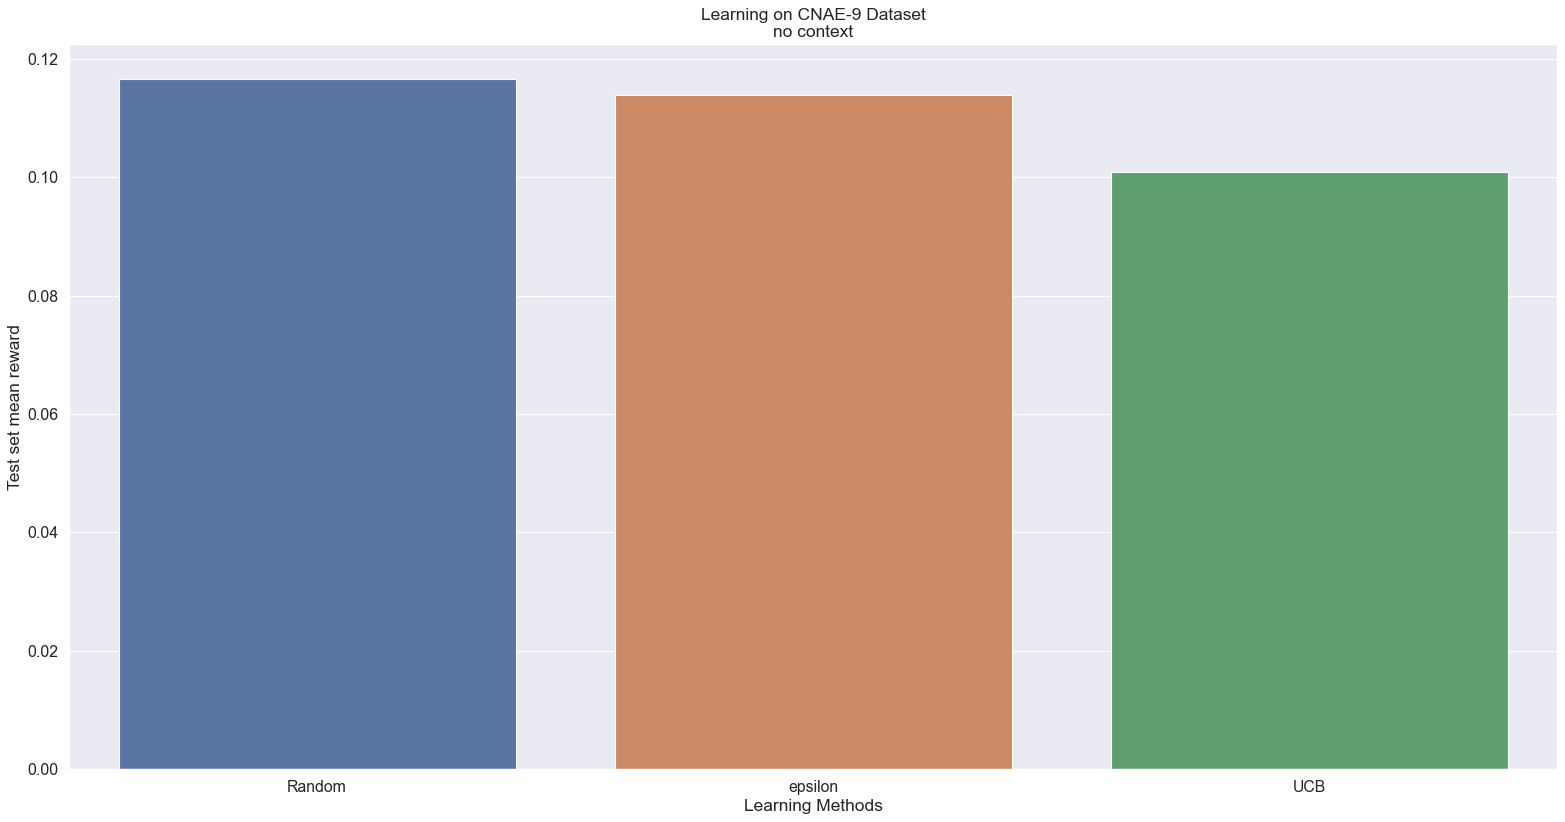

In [21]:
figure(figsize=(24, 12), dpi=80)
results = pd.DataFrame({
    'Learning Methods' : ['Random', 'epsilon', 'UCB'],
    'Test set mean reward' : [rand_avgs[-1], epsilon_average[-1], UCB_averages[-1]]
})

sns.set(font_scale = 1.3)
sns.barplot(x = "Learning Methods", y="Test set mean reward", data=results)
plt.title('Learning on CNAE-9 Dataset\nno context')
plt.show()